In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from pyronn.ct_reconstruction.geometry.geometry import Geometry
from pyronn.ct_reconstruction.helpers.phantoms import shepp_logan
from pyronn.ct_reconstruction.helpers.trajectories.circular_trajectory import circular_trajectory_2d
from pyronn.ct_reconstruction.layers.projection_2d import ParallelProjection2D

# Initializing CT geometry parameters:

# Volume parameters:
volume_size = 362  # size of the volume/image
volume_shape = [volume_size, volume_size]  # shape of the volume as [height, width]
volume_spacing = [1, 1]  # spacing between pixels in the volume

# Detector parameters:
detector_shape = [513]  # shape of the detector
detector_spacing = [1]  # spacing between detector pixels

# Trajectory parameters:
number_of_projections = 1000  # number of projections in the sinogram
angular_range = -np.pi  # angular range of the trajectory (half-circle in this case)

# Create an instance of the Geometry class and initialize it with the above parameters
geometry = Geometry()
geometry.init_from_parameters(volume_shape=volume_shape, volume_spacing=volume_spacing,
                              detector_shape=detector_shape, detector_spacing=detector_spacing,
                              number_of_projections=number_of_projections, angular_range=angular_range,
                              trajectory=circular_trajectory_2d)


In [2]:
phantom = shepp_logan.shepp_logan_enhanced(volume_shape)
phantom = torch.tensor(np.expand_dims(phantom, axis=0).copy(), dtype=torch.float32).cuda()

sinogram = ParallelProjection2D().forward(phantom, **geometry)

In [3]:
class IterativeRecoModel(nn.Module):
    def __init__(self, geo: Geometry):
        super().__init__()
        self.geometry = geo
        self.reco = nn.Parameter(torch.zeros(geo.volume_shape))
        self.A = ParallelProjection2D()

    def forward(self, x):
        updated_reco = x + self.reco.cuda()
        current_sino = self.A(updated_reco, **self.geometry)
        return current_sino, self.reco.cuda()


In [4]:
class Pipeline:
    def __init__(self, ir, geo, epoches=100):
        self.ir = ir
        self.epoches = epoches
        self.geometry = geo
        self.model = IterativeRecoModel(geo)
        self.regularizer_weight = 0.003
        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.ir)

    def loss(self, prediction, label, regular=True):
        def compute_tv_loss(prediction):
            # Calculate the difference in the horizontal direction (left-right)
            diff_horz = torch.sum(torch.abs(prediction[:, :, :-1] - prediction[:, :, 1:]))
            # Calculate the difference in the vertical direction (up-down)
            diff_vert = torch.sum(torch.abs(prediction[:, :-1, :] - prediction[:, 1:, :]))
            # Combine the two differences
            tv_loss = (
                              diff_horz + diff_vert) / prediction.numel()  # Normalize by number of elements in the prediction tensor
            return tv_loss

        mse_loss = nn.MSELoss()(prediction, label)
        tv_loss = 0
        if regular:
            tv_loss = compute_tv_loss(prediction)
        return mse_loss + self.regularizer_weight * tv_loss

    def train(self, input, label, regular: bool):
        loss_values = []
        for epoch in range(self.epoches):
            self.optimizer.zero_grad()
            predictions, current_reco = self.model(input)
            loss_value = self.loss(predictions, label, regular)
            loss_value.backward()
            self.optimizer.step()
            loss_values.append(loss_value.item())
        return loss_values



In [10]:
pipeline_instance = Pipeline(ir=1e-1, geo=geometry, epoches=100)

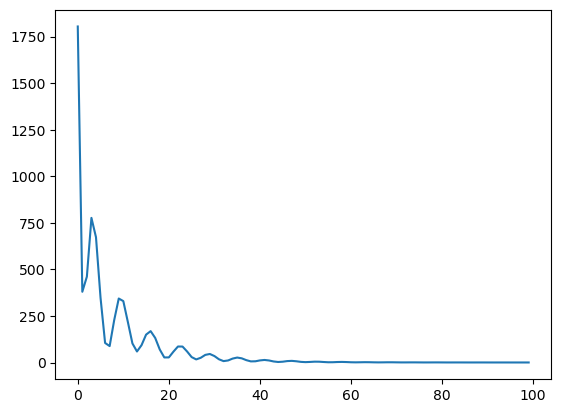

In [11]:
ini_guess = torch.zeros_like(phantom)
loss_value = pipeline_instance.train(ini_guess, sinogram, True)
plt.figure()
plt.plot(loss_value)

In [12]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """Normalize the pixel values of an image to the range [0, 1]."""
    return image / np.mean(image)

# def normalize_image(image: np.ndarray) -> np.ndarray:
#     """Normalize the pixel values of an image to the range [0, 1] while preserving contrast."""
#     min_val = np.min(image)
#     max_val = np.max(image)
# 
#     return (image - min_val) / (max_val - min_val)

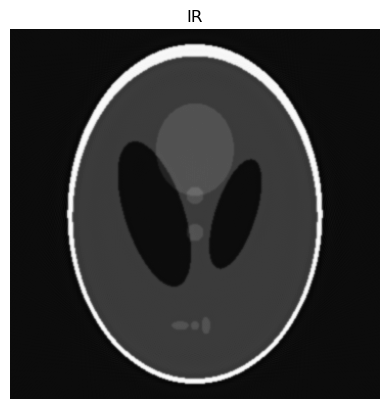

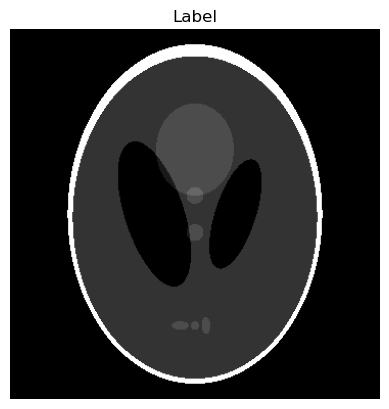

In [13]:
reco = pipeline_instance.model.reco.cpu().detach().numpy()

plt.figure()
plt.imshow(normalize_image(reco), cmap="gray")
plt.axis("off")
plt.title('IR')
plt.show()

plt.figure()
plt.imshow((phantom.squeeze().cpu().numpy()), cmap="gray")
plt.title('Label')
plt.axis("off")
plt.show()

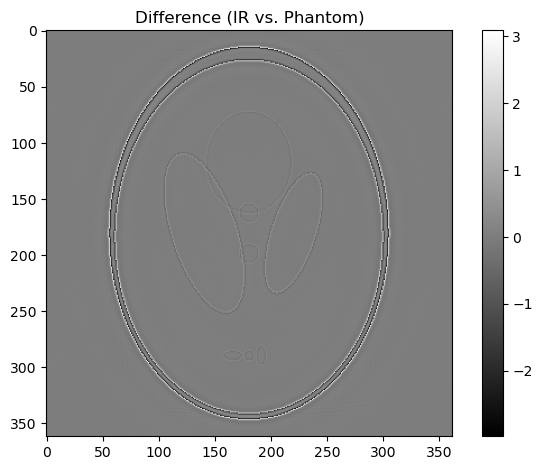

Mean Squared Error (MSE) between IR and Phantom: 0.1007


In [14]:
difference_ir = normalize_image(reco) - normalize_image(phantom.squeeze().cpu().numpy())
plt.imshow(difference_ir, cmap='gray')
plt.title('Difference (IR vs. Phantom)')
plt.colorbar()
plt.tight_layout()
plt.show()

# Calculate the MSE for each reconstruction method.
mse_ir = np.mean(difference_ir ** 2)

print(f"Mean Squared Error (MSE) between IR and Phantom: {mse_ir:.4f}")